importing libraries

In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

loading and exploring dataset

In [5]:
# Path to the zipped file
zip_file_path = 'A_Z_Handwritten_Data.zip'

# Unzip and read the file
with zipfile.ZipFile(zip_file_path, 'r') as zipf:
    # Extract file name inside the zip
    file_name = zipf.namelist()[0]  # Assumes there's only one file in the zip
    
    # Open the file and load it into a DataFrame
    with zipf.open(file_name) as file:
        data = pd.read_csv(file)

In [6]:
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data.shape

(372450, 785)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 2.2 GB


In [9]:
data.duplicated().any()

np.True_

In [42]:
data = data.drop_duplicates()

In [43]:
data.duplicated().any()

np.False_

In [44]:
data.shape

(201095, 785)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201095 entries, 0 to 372448
Columns: 785 entries, 0 to 0.648
dtypes: float32(785)
memory usage: 603.7 MB


In [33]:
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
x = data.drop('0', axis=1)
y = data['0']

splitting and reshaping data

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)

one hot encoding of labels

In [48]:
y_train_enc = to_categorical(y_train, num_classes=26)
y_test_enc = to_categorical(y_test, num_classes=26)

visualizing dataset distribution

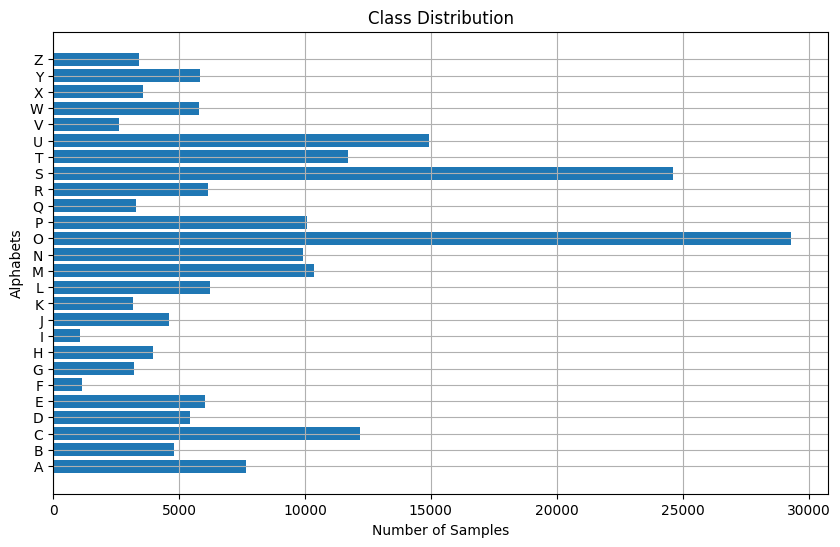

In [49]:
alphabet_map = {i: chr(65 + i) for i in range(26)}
counts = y.value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.barh([alphabet_map[i] for i in counts.index], counts.values)
plt.xlabel('Number of Samples')
plt.ylabel('Alphabets')
plt.title('Class Distribution')
plt.grid(True)
plt.show()

displaying sample images

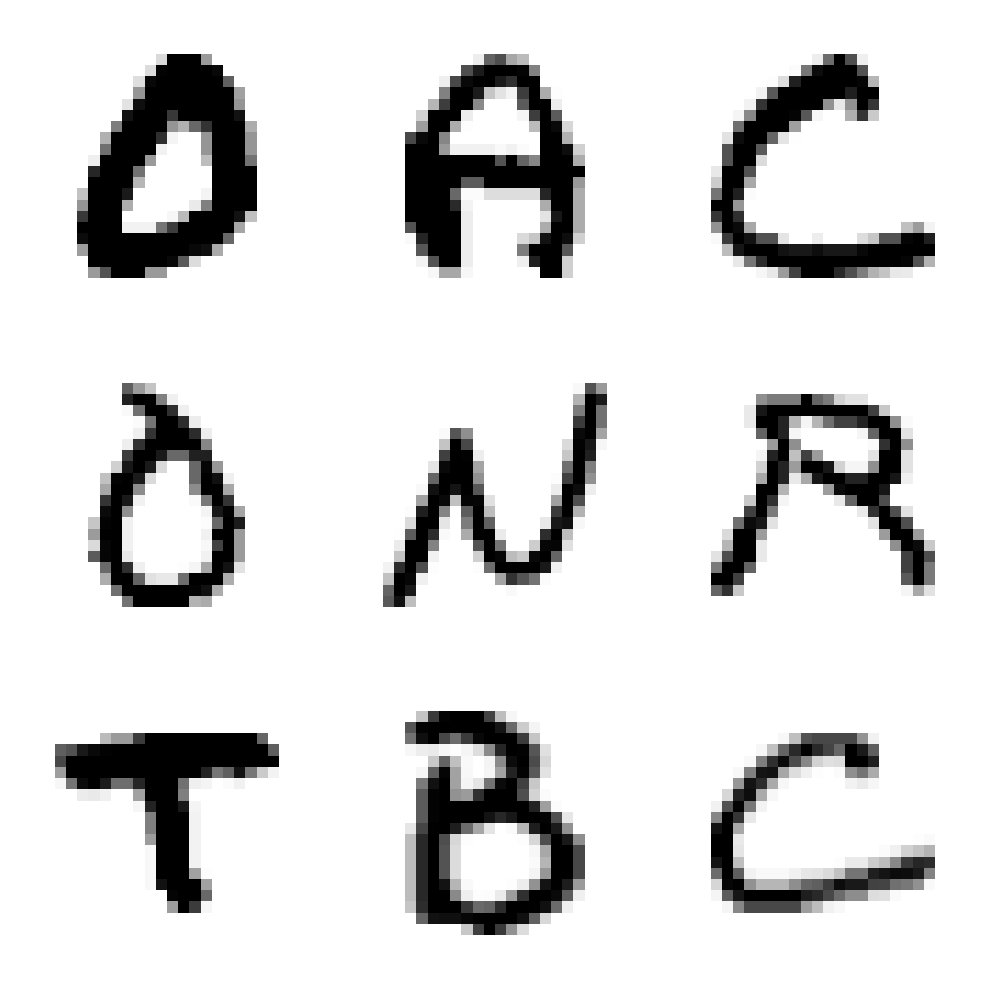

In [50]:
sample_images = shuffle(x_train[:9])
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_images[i].reshape(28, 28), cmap='Greys')
    ax.axis('off')
plt.tight_layout()
plt.show()

defining model

In [51]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='valid'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(26, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

training model

In [52]:
model = create_model()
history = model.fit(x_train, y_train_enc, epochs= 3, validation_data=(x_test, y_test_enc), batch_size=64)

c:\Users\ocran\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 104s 40ms/step - accuracy: 0.8440 - loss: 0.7519 - val_accuracy: 0.9679 - val_loss: 0.1123
Epoch 2/3
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 97s 39ms/step - accuracy: 0.9738 - loss: 0.0938 - val_accuracy: 0.9734 - val_loss: 0.0953
Epoch 3/3
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 102s 40ms/step - accuracy: 0.9795 - loss: 0.0722 - val_accuracy: 0.9785 - val_loss: 0.0776


saving trained model

In [53]:
#model.save('model_hand.h5')


In [54]:
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")

Training Accuracy: 0.9788781404495239
Validation Accuracy: 0.9785425066947937


visualizing accuracy metrics

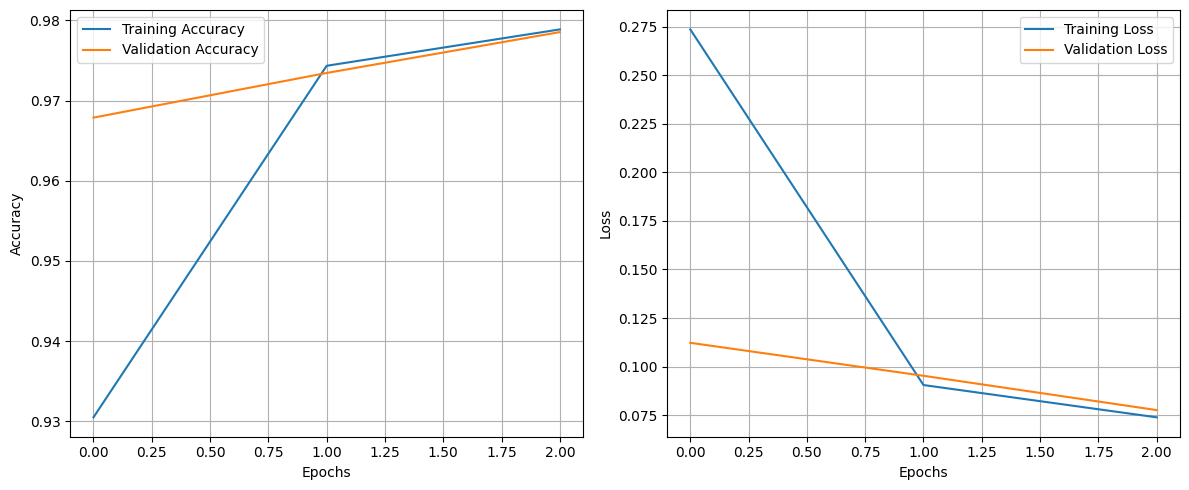

In [55]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

predicting test samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


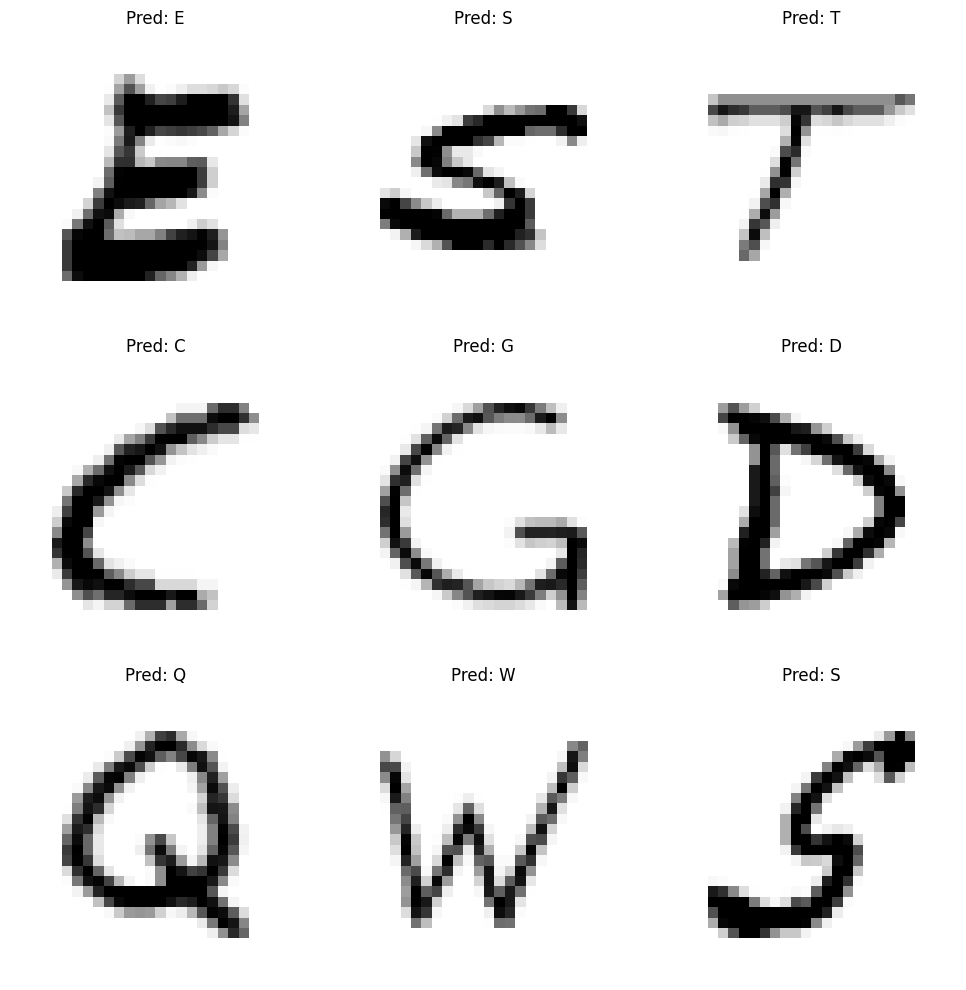

In [56]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = x_test[i].reshape(28, 28)
    pred_label = alphabet_map[np.argmax(model.predict(img.reshape(1, 28, 28, 1)))]
    ax.imshow(img, cmap='Greys')
    ax.set_title(f"Pred: {pred_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

function for prepocessing image before prediction

In [57]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV)[1]
    return img.reshape(1, 28, 28, 1)


predictions

In [58]:
test_image = preprocess_image('e.png')
pred = alphabet_map[np.argmax(model.predict(test_image))]
print(f"Prediction: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Prediction: E


In [59]:
test_image = preprocess_image('c.png')
pred = alphabet_map[np.argmax(model.predict(test_image))]
print(f"Prediction: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: C
